In [1]:
import numpy as np
import xarray as xr
import re
from pathlib import Path
import collections
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.font_manager as fm
# import seaborn as sns
import pandas as pd
import os
import pickle
#sns.set_style("dark")
from utils import *

In [2]:
# CONFIGURE SCRIPT
# Where to find Alchemist data files
directory = '../data'
# Where to save charts
output_directory = '../charts/custom-charts'
# How to name the summary of the processed data
pickleOutput = 'data_summary'
# Experiment prefixes: one per experiment (root of the file name)
experiments = ['load_based']
floatPrecision = '{: 0.3f}'
# Number of time samples 
timeSamples = 720
# time management
minTime = 60
maxTime = 3600
timeColumnName = 'time'
logarithmicTime = False
excludeVariables = []
# One or more variables are considered random and "flattened"
seedVars = ['random']
# Label mapping

In [3]:
if os.path.exists(directory):
    newestFileTime = max([os.path.getmtime(directory + '/' + file) for file in os.listdir(directory)], default=0.0)
    try:
        lastTimeProcessed = pickle.load(open('timeprocessed', 'rb'))
    except:
        lastTimeProcessed = -1
    shouldRecompute = not os.path.exists(".skip_data_process") and newestFileTime != lastTimeProcessed
    if not shouldRecompute:
        try:
            means = pickle.load(open(pickleOutput + '_mean', 'rb'))
            stdevs = pickle.load(open(pickleOutput + '_std', 'rb'))
        except:
            shouldRecompute = True
    if shouldRecompute:
        timefun = np.logspace if logarithmicTime else np.linspace
        means = {}
        stdevs = {}
        for experiment in experiments:
            # Collect all files for the experiment of interest
            import fnmatch
            allfiles = filter(lambda file: fnmatch.fnmatch(file, experiment + '_*.csv'), os.listdir(directory))
            allfiles = [directory + '/' + name for name in allfiles]
            allfiles.sort()
            # From the file name, extract the independent variables
            dimensions = {}
            for file in allfiles:
                dimensions = mergeDicts(dimensions, extractCoordinates(file, excludeVariables))
            dimensions = {k: sorted(v) for k, v in dimensions.items()}
            # Add time to the independent variables
            dimensions[timeColumnName] = range(0, timeSamples)
            print(dimensions)
            # Compute the matrix shape
            shape = tuple(len(v) for k, v in dimensions.items())
            # Prepare the Dataset
            dataset = xr.Dataset()
            for k, v in dimensions.items():
                dataset.coords[k] = v
            if len(allfiles) == 0:
                print("WARNING: No data for experiment " + experiment)
                means[experiment] = dataset
                stdevs[experiment] = xr.Dataset()
            else:
                varNames = extractVariableNames(allfiles[0])
                for v in varNames:
                    if v != timeColumnName:
                        novals = np.ndarray(shape)
                        novals.fill(float('nan'))
                        dataset[v] = (dimensions.keys(), novals)
                # Compute maximum and minimum time, create the resample
                timeColumn = varNames.index(timeColumnName)
                allData = { file: np.matrix(openCsv(file)) for file in allfiles }
                computeMin = minTime is None
                computeMax = maxTime is None
                if computeMax:
                    maxTime = float('-inf')
                    for data in allData.values():
                        maxTime = max(maxTime, data[-1, timeColumn])
                if computeMin:
                    minTime = float('inf')
                    for data in allData.values():
                        minTime = min(minTime, data[0, timeColumn])
                timeline = timefun(minTime, maxTime, timeSamples)
                # Resample
                for file in allData:
#                    print(file)
                    allData[file] = convert(timeColumn, timeline, allData[file])
                # Populate the dataset
                for file, data in allData.items():
                    dataset[timeColumnName] = timeline
                    for idx, v in enumerate(varNames):
                        if v != timeColumnName:
                            darray = dataset[v]
                            experimentVars = extractCoordinates(file, excludeVariables)
                            darray.loc[experimentVars] = data[:, idx].A1
                # Fold the dataset along the seed variables, producing the mean and stdev datasets
                mergingVariables = [seed for seed in seedVars if seed in dataset.coords]
                means[experiment] = dataset.mean(dim = mergingVariables, skipna=True)
                stdevs[experiment] = dataset.std(dim = mergingVariables, skipna=True)
        # Save the datasets
        pickle.dump(means, open(pickleOutput + '_mean', 'wb'), protocol=-1)
        pickle.dump(stdevs, open(pickleOutput + '_std', 'wb'), protocol=-1)
        pickle.dump(newestFileTime, open('timeprocessed', 'wb'))
else:
    means = { experiment: xr.Dataset() for experiment in experiments }
    stdevs = { experiment: xr.Dataset() for experiment in experiments }

# QoS Analysis for load balancing scenario

## Lobster network

In [4]:
dataset = means['load_based']
stdevs = stdevs['load_based']
dataset

<xarray.Dataset>
Dimensions:              (devices: 3, network: 2, computationalCost: 3,
                          load: 2, behavior: 2, time: 359)
Coordinates:
  * devices              (devices) float64 25.0 100.0 1e+03
  * network              (network) <U8 'barabasi' 'lobster'
  * computationalCost    (computationalCost) float64 1.0 3.0 10.0
  * load                 (load) float64 0.0 1.0
  * behavior             (behavior) <U8 'advanced' 'simple'
  * time                 (time) float64 60.0 69.89 79.78 ... 3.59e+03 3.6e+03
Data variables:
    canOffload[sum]      (devices, network, computationalCost, load, behavior, time) float64 ...
    wantToOffload[sum]   (devices, network, computationalCost, load, behavior, time) float64 ...
    qos                  (devices, network, computationalCost, load, behavior, time) float64 ...
    effectiveLoad[mean]  (devices, network, computationalCost, load, behavior, time) float64 ...
    effectiveLoad[max]   (devices, network, computationalCost, load, behavior, time) float64 ...
    effectiveLoad[min]   (devices, network, computationalCost, load, behavior, time) float64 ...
    load[mean]           (devices, network, computationalCost, load, behavior, time) float64 ...
    latency[mean]        (devices, network, computationalCost, load, behavior, time) float64 ...
    latency[max]         (devices, network, computationalCost, load, behavior, time) float64 ...
    latency[min]         (devices, network, computationalCost, load, behavior, time) float64 ...

In [12]:
lobster = dataset.sel({"network": "lobster" }, drop=True)
lobster_stdevs = stdevs.sel({"network": "lobster" }, drop=True)

barabasi = dataset.sel({"network": "barabasi" }, drop=True)
barabasi_stdevs = stdevs.sel({"network": "barabasi" }, drop=True)

In [13]:
def extract_values(dataset, stdevs, behaviour, computational_cost, devices, load):
    values = dataset.sel({"behavior": behaviour, "computationalCost": computational_cost, "devices": devices, "load": load }, drop=True)["qos"].to_numpy()
    errors = stdevs.sel({"behavior": behaviour, "computationalCost": computational_cost, "devices": devices, "load": load }, drop=True)["canOffload[sum]"].to_numpy() / devices
    plus_errors = values + errors
    minus_errors = values - errors
    return (values, plus_errors, minus_errors)

Barabasi


/home/nicolas/Documents/repos/reconfiguration-experiments/data-visualization/env/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


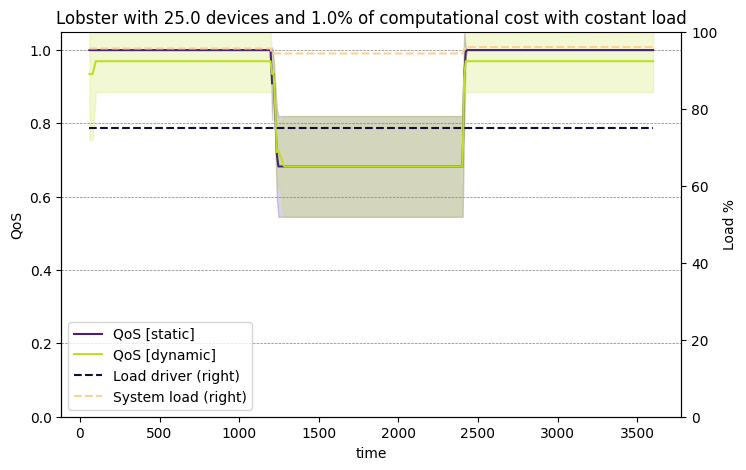

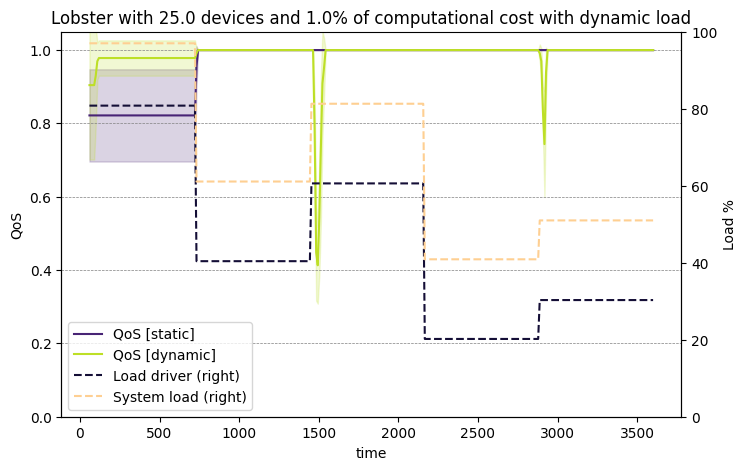

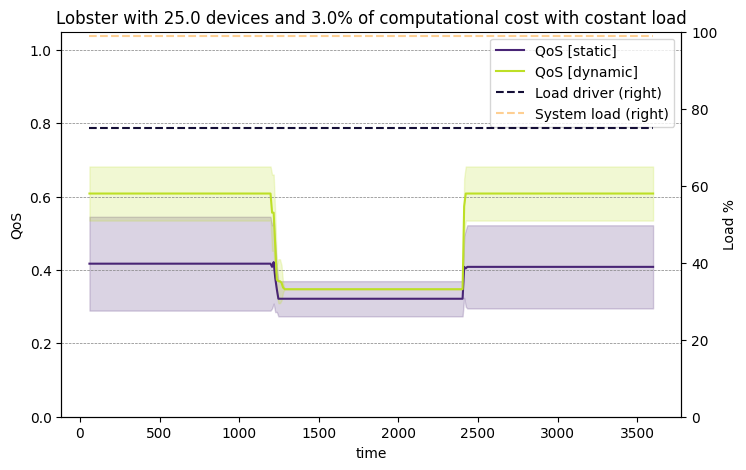

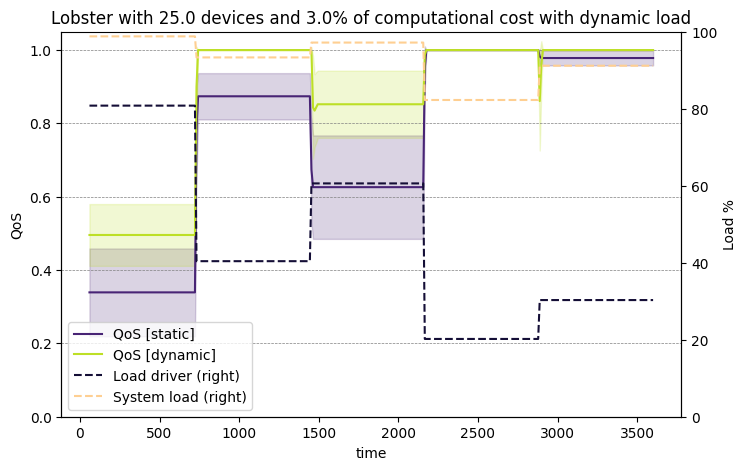

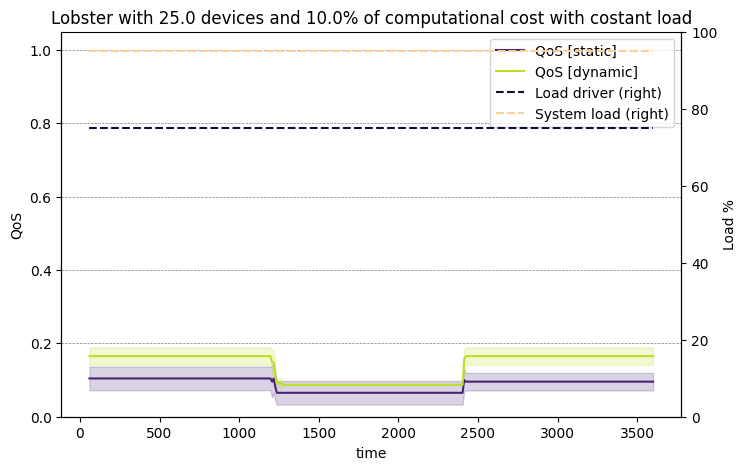

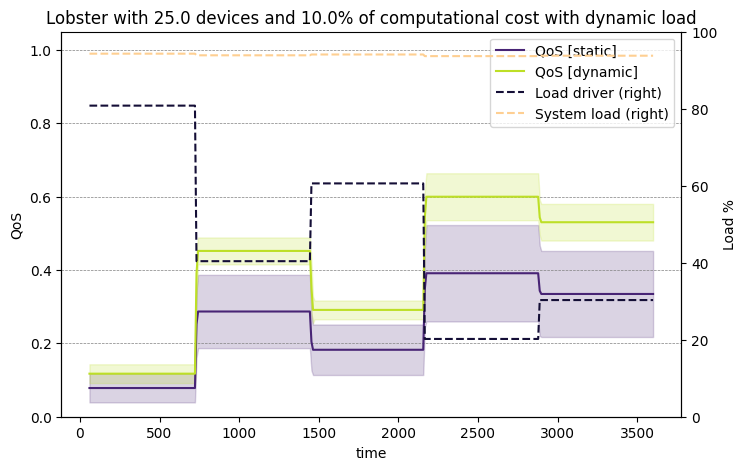

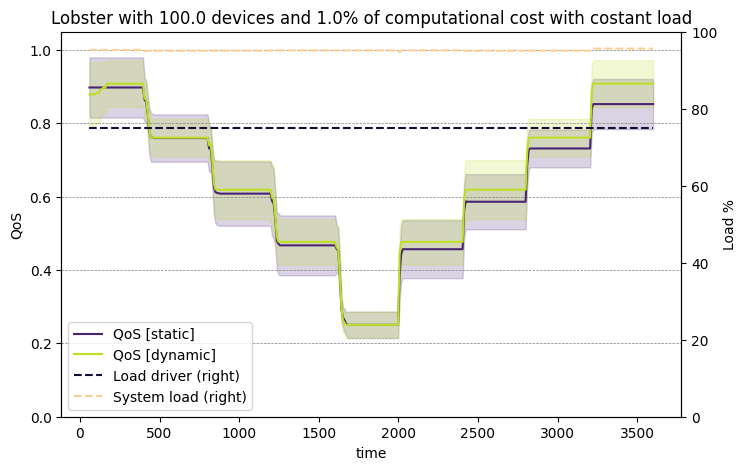

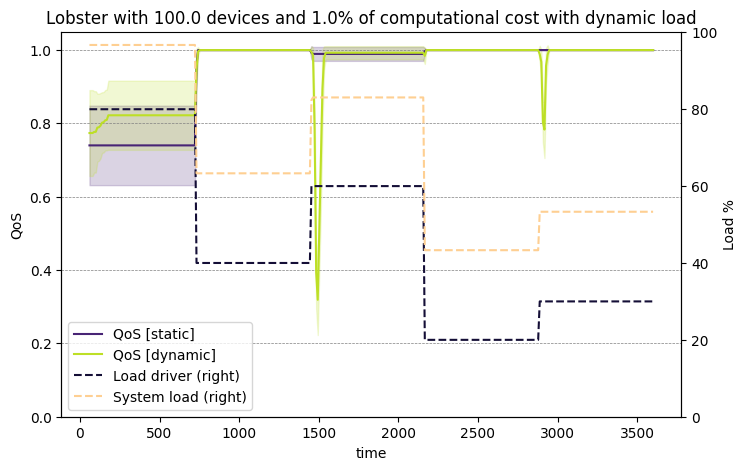

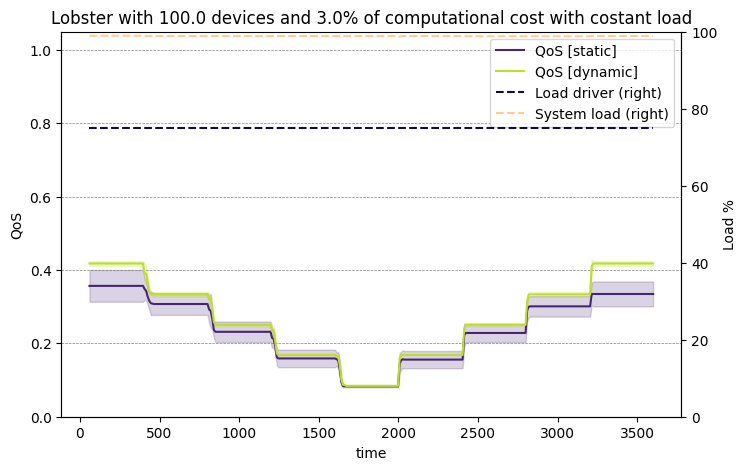

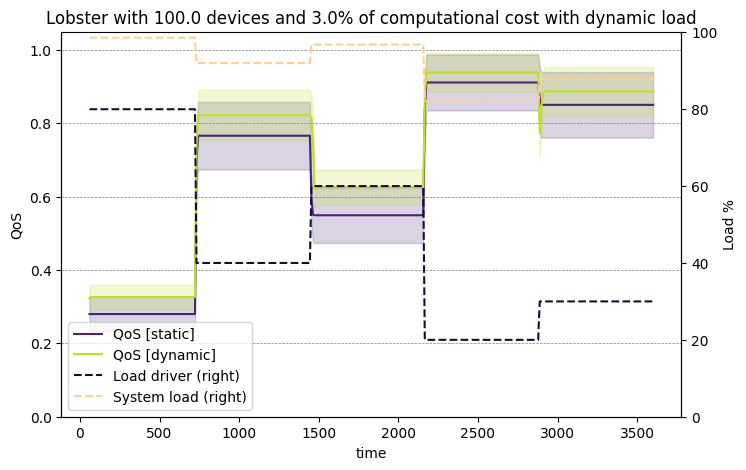

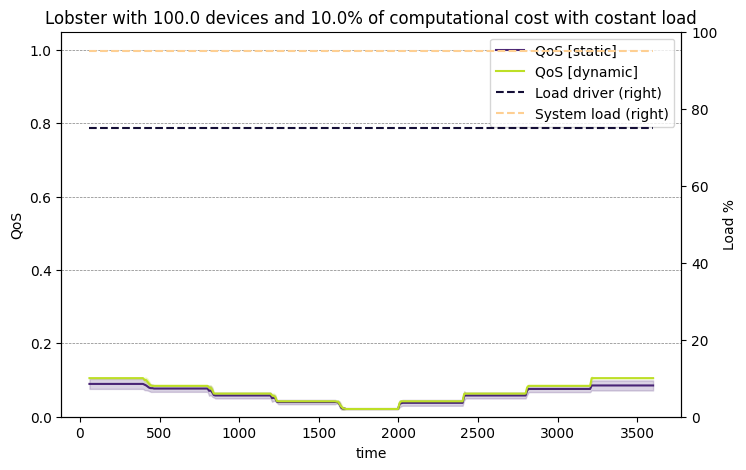

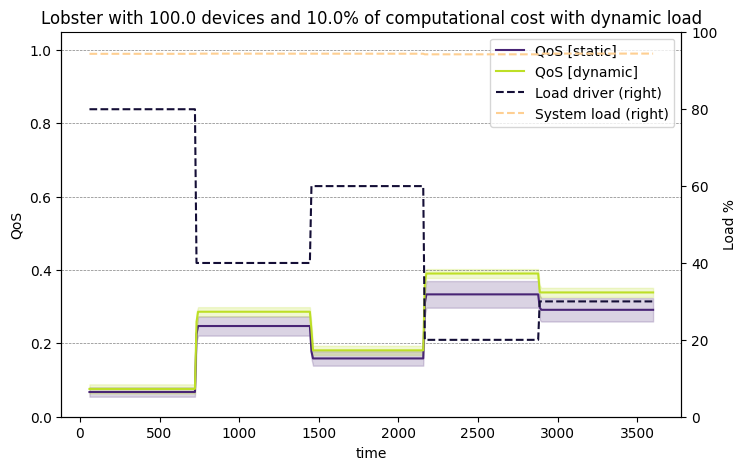

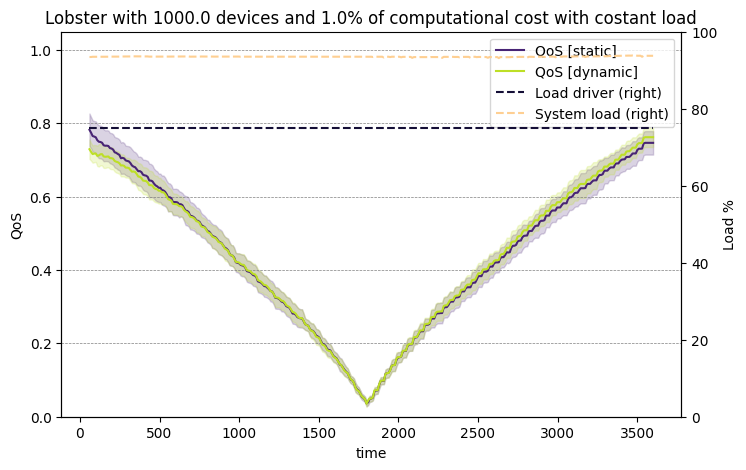

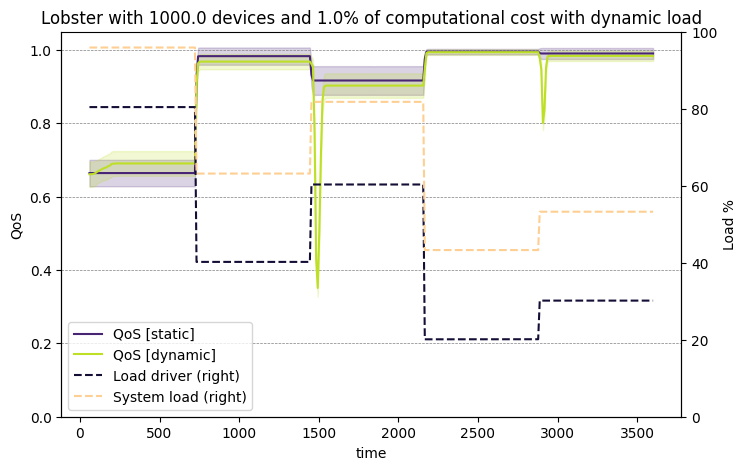

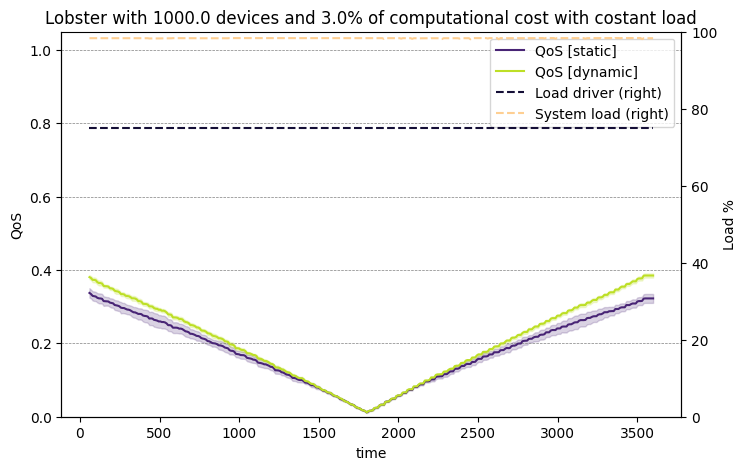

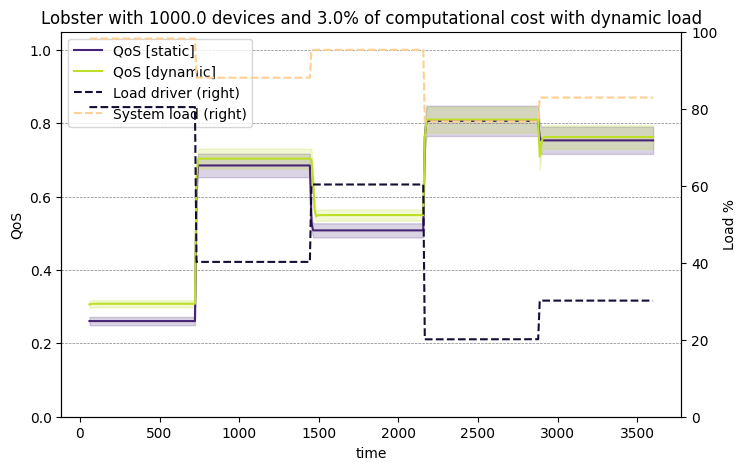

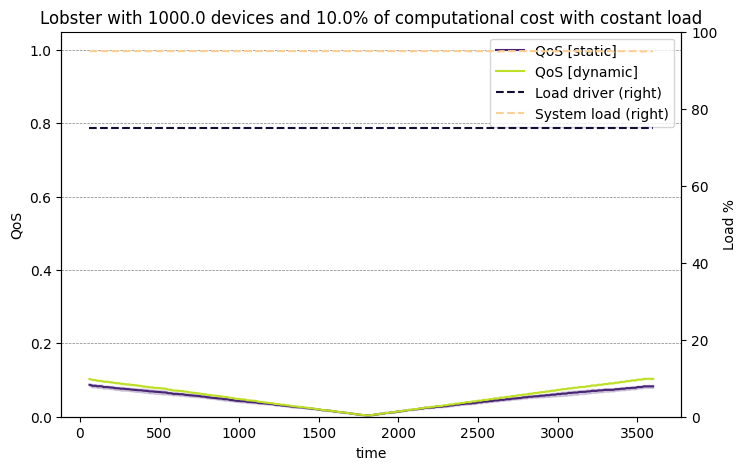

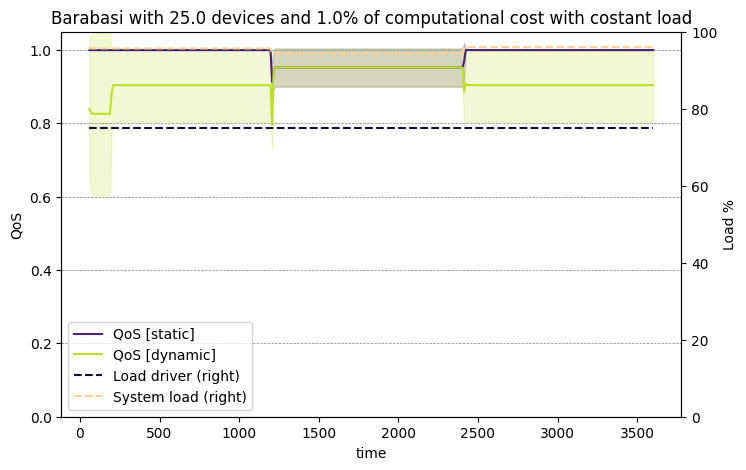

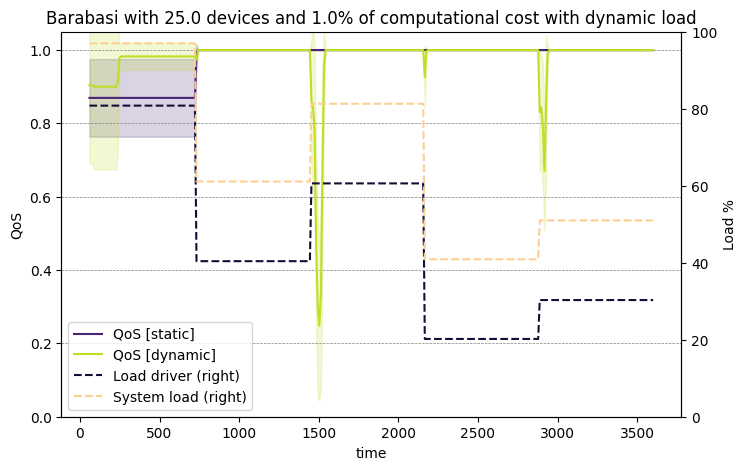

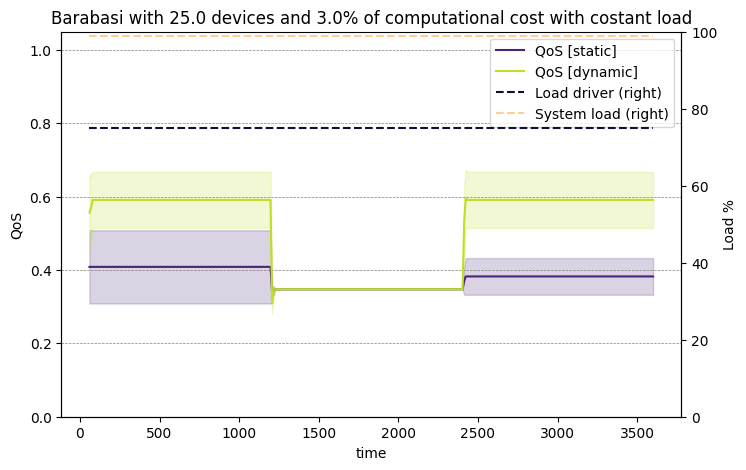

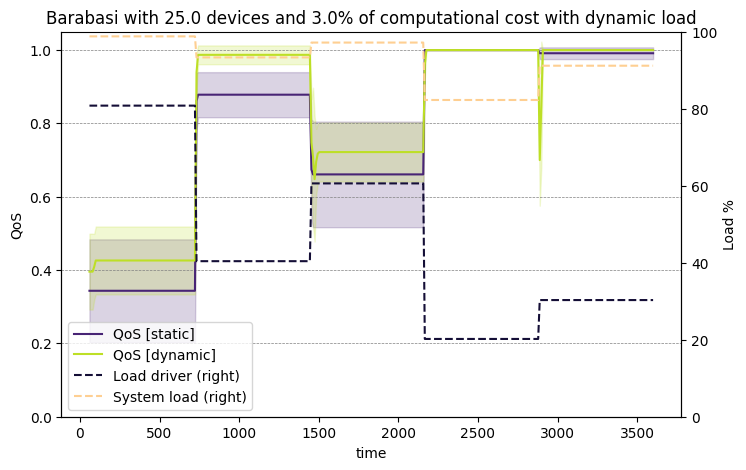

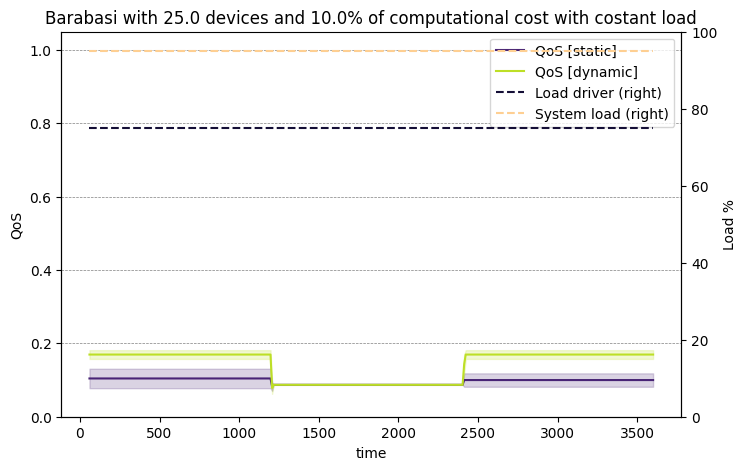

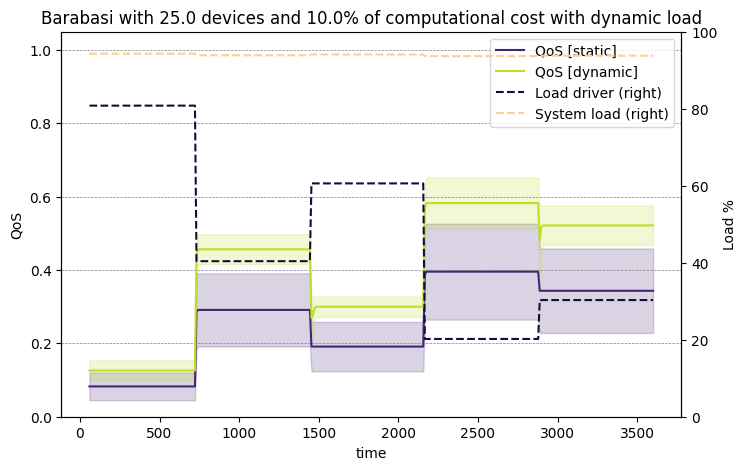

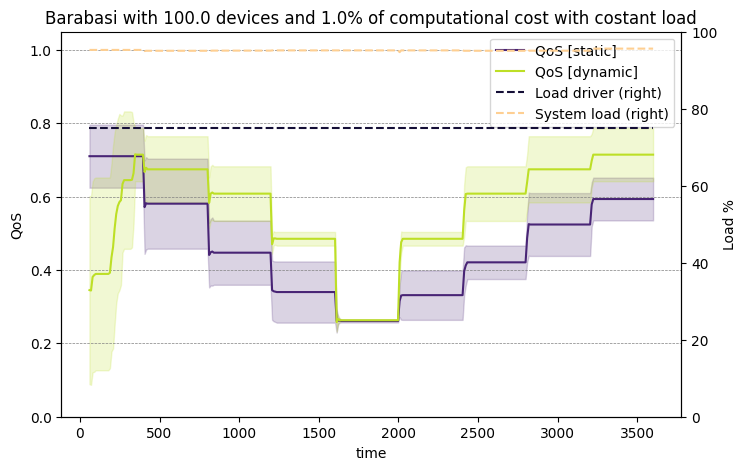

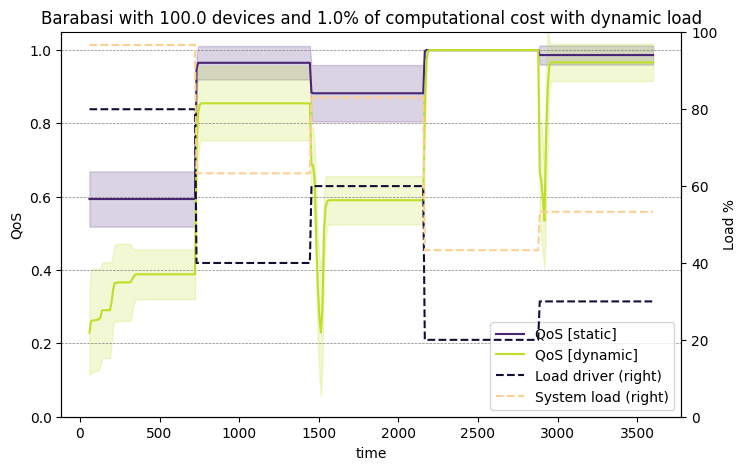

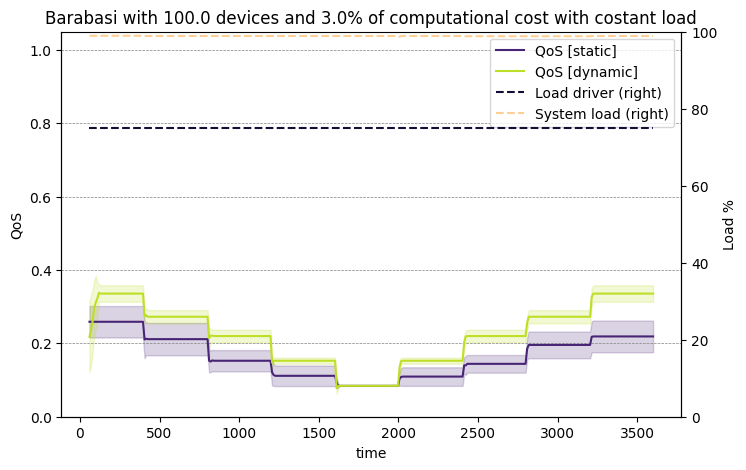

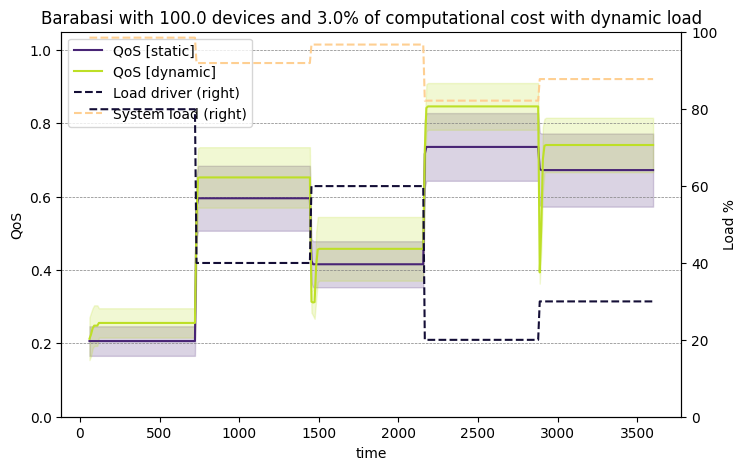

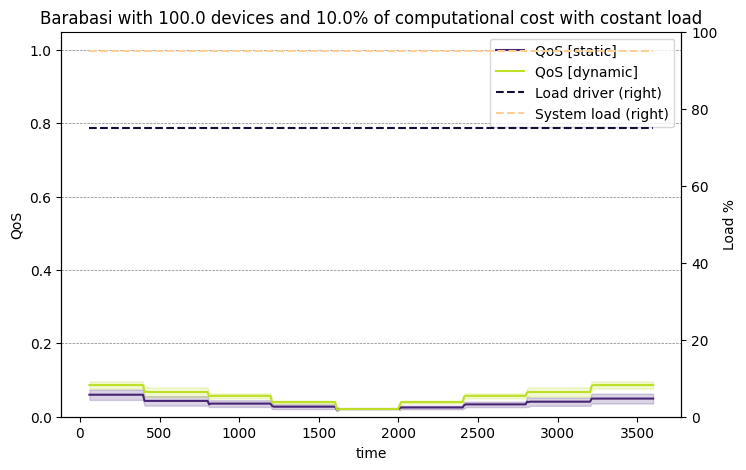

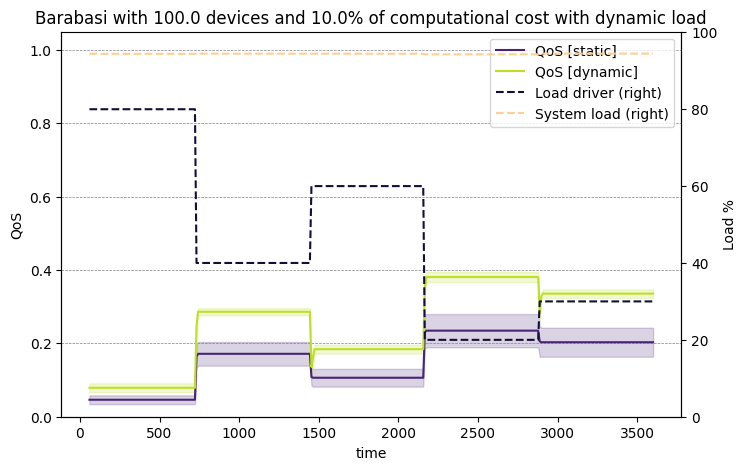

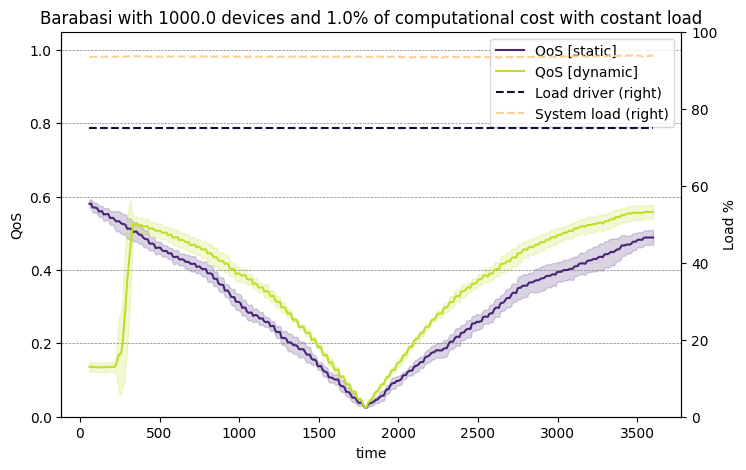

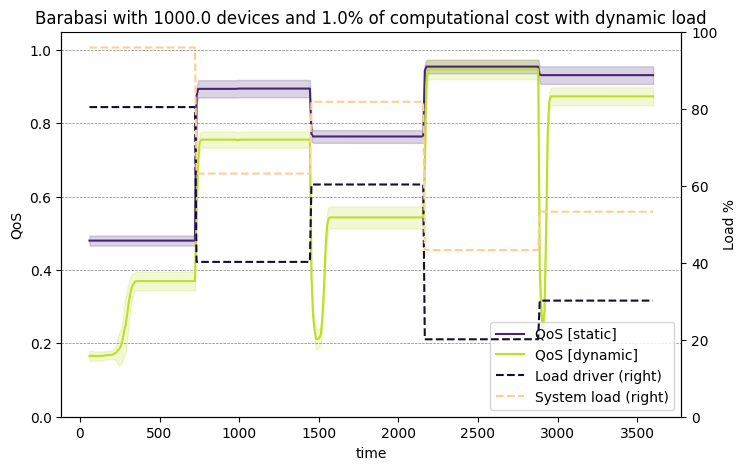

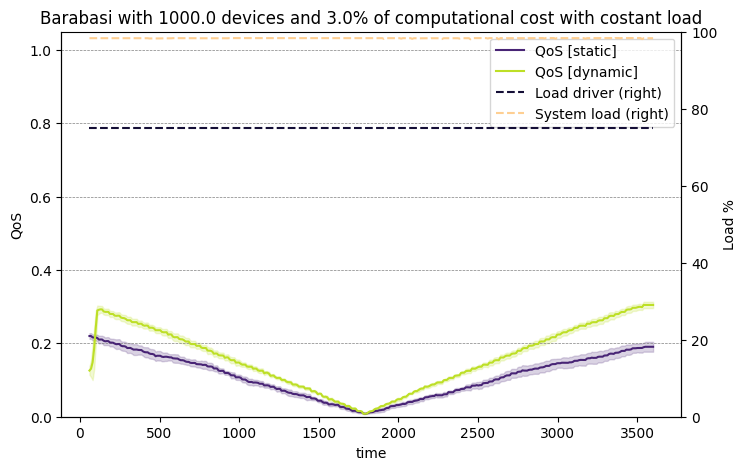

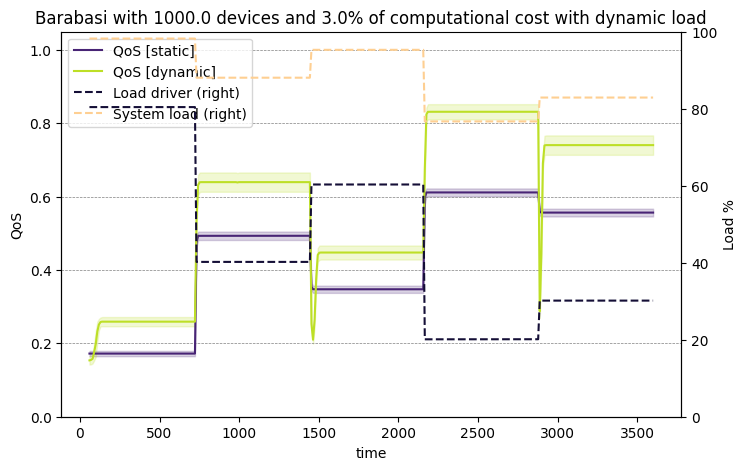

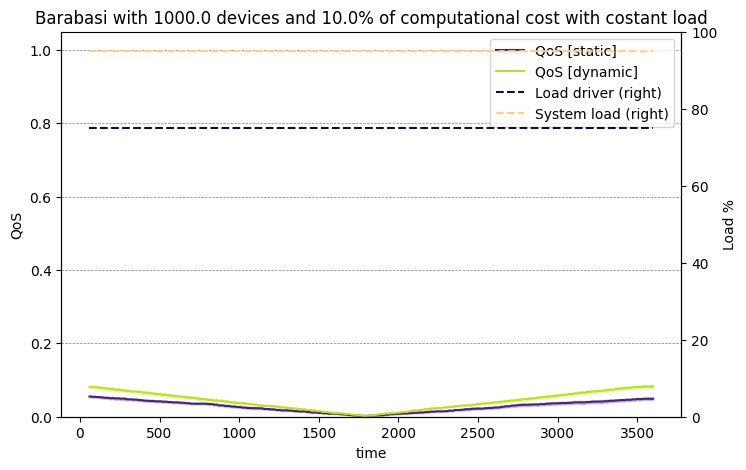

In [14]:
x_time = lobster['time'].to_numpy()

behavior = dataset.coords["behavior"].values
devices = dataset.coords["devices"].values
computationalCost = dataset.coords["computationalCost"].values
load = dataset.coords["load"].values

import matplotlib.cm as cmx

colorscale_margin = 0.1

def lammerda(colormap, x):
    return colormap(x*(1-colorscale_margin * 2) + colorscale_margin)

def print_charts(dataset, stdev, net):
    for dev in devices:
        for compCost in computationalCost:
            for ld in load:
                (simple_values, simple_plus_errors, simple_minus_errors) = extract_values(dataset, stdev, "simple", compCost, dev, ld)
                (advanced_values, advanced_plus_errors, advanced_minus_errors) = extract_values(dataset, stdev, "advanced", compCost, dev, ld)
                load_driver = lobster.sel({"behavior": "simple", "computationalCost": compCost, "devices": dev, "load": ld }, drop=True)["load[mean]"].to_numpy()
                effective_load = lobster.sel({"behavior": "simple", "computationalCost": compCost, "devices": dev, "load": ld }, drop=True)["effectiveLoad[mean]"].to_numpy()
                dataset_plot = pd.DataFrame({ "time": x_time, "QoS [static]": simple_values, "QoS [dynamic]": advanced_values, "Load driver": load_driver, "System load": effective_load })
                #fig, ax = plt.subplots(figsize=(8,4))
                
                ax = dataset_plot.plot(x="time", y=["QoS [static]", "QoS [dynamic]"], ylabel="QoS", figsize=(8, 5), ylim=(0, 1.05), colormap=lambda x: lammerda(cmx.viridis, x))
                dataset_plot.plot(x="time", y=["Load driver", "System load"], ylabel="Load %", secondary_y = True, ax=ax, linestyle="dashed", ylim=(0, 100.05), colormap=lambda x: lammerda(cmx.magma, x))
    
                ax.set_title("{0} with {1} devices and {2}% of computational cost with {3} load".format(net, dev, compCost, "costant" if ld == 0.0 else "dynamic"))
                ax.fill_between(x_time, simple_plus_errors, simple_minus_errors, alpha=0.2, color=lammerda(cmx.viridis, 0))
                ax.fill_between(x_time, advanced_plus_errors, advanced_minus_errors, alpha=0.2, color=lammerda(cmx.viridis, 1))
                ax.set_facecolor("white")
                ax.get_xaxis().set_visible(True)
                ax.grid(axis = 'y', color = 'gray', linestyle = '--', linewidth = 0.5)
                ax.spines['top'].set_visible(False)

    matplotlib.pyplot.close()

print_charts(lobster, lobster_stdevs, "Lobster")

print("Barabasi")

print_charts(barabasi, barabasi_stdevs, "Barabasi")